In [7]:
pip install qblox-instruments quantify-core quantify-scheduler

Note: you may need to restart the kernel to use updated packages.


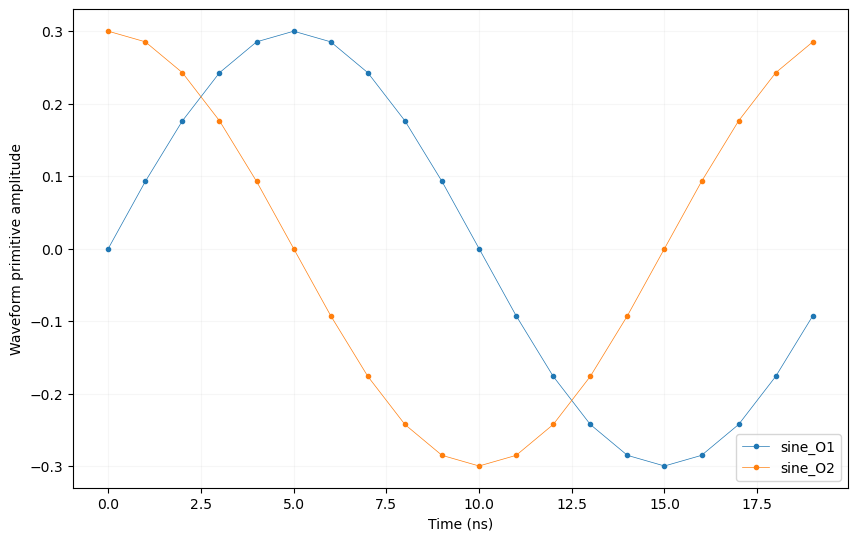

Status: OKAY, State: STOPPED, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, Warning Flags: NONE, Error Flags: NONE, Log: []
Snapshot:
cluster_mm_module2:
	parameter                    value
--------------------------------------------------------------------------------
in0_gain                      :	-6 (dB)
in0_offset                    :	0 (V)
in1_gain                      :	-6 (dB)
in1_offset                    :	0 (V)
marker0_inv_en                :	False 
marker1_inv_en                :	False 
marker2_inv_en                :	False 
marker3_inv_en                :	False 
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
present                       :	True 
scope_acq_avg_mode_en_path0   :	False 
scope_acq_avg_mode_en_path1   :	False 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
sc

In [33]:
from __future__ import annotations

import json
import math
from typing import TYPE_CHECKING

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from qcodes.instrument import find_or_create_instrument

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from qblox_instruments.qcodes_drivers.module import QcmQrm

cluster_ip = "192.168.0.2"
cluster_name = "cluster_mm"

cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)
module = cluster.modules[1]

# 波形參數
waveform_length = 20  # nanoseconds (needs to be a minimum of 4 ns)

# 設置振幅、DC 偏移和相位偏移
sine_amplitude_01 = 0.3
sine_amplitude_02 = 0.3
dc_offset_01 = 0
dc_offset_02 = 0
phase_offset_O1 = 0
phase_offset_O2 = math.pi/2  # 相位偏移為 π/2 (90 度)

# 波形字典 (data will hold the samples and index will be used to select the waveforms in the instrument)
waveforms = {
    "sine_O1": {
        "data": [
            sine_amplitude_01 *
            math.sin((2 * math.pi / waveform_length)
                     * i + phase_offset_O1) + dc_offset_01
            for i in range(0, waveform_length)
        ],
        "index": 0,
    },
    "sine_O2": {
        "data": [
            sine_amplitude_02 *
            math.sin((2 * math.pi / waveform_length)
                     * i + phase_offset_O2) + dc_offset_02
            for i in range(0, waveform_length)
        ],
        "index": 1,
    },
}

# 繪製波形
time = np.arange(0, waveform_length, 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time, d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.grid(alpha=1 / 10)
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

plt.draw()
plt.show()

# 序列程序
seq_prog = "stop"

# 檢查波形長度
for name in waveforms:
    assert len(waveforms[name]["data"]
               ) % 4 == 0, "In continuous waveform mode the length of a waveform must be a multiple of 3!"

# 添加序列程序和波形到單一字典並寫入 JSON 文件
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": {},
    "program": seq_prog,
}
with open("cont_wave_mode_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)

# 上傳序列
module.sequencer0.sequence("cont_wave_mode_sequence.json")

# 配置 sequencer 以運行連續波形模式
module.sequencer0.cont_mode_en_awg_path0(True)
module.sequencer0.cont_mode_en_awg_path1(True)

# 映射 sequencer 到特定輸出
module.disconnect_outputs()
module.sequencer0.connect_sequencer("out0_1")

# 將特定波形設置到特定輸出
module.sequencer0.cont_mode_waveform_idx_awg_path0(0)  # Sine on O1
module.sequencer0.cont_mode_waveform_idx_awg_path1(
    1)  # Sine on O2 with 90-degree phase offset

# Arm and start the sequencer.
module.arm_sequencer(0)
module.start_sequencer()

# 打印 sequencer 的狀態
print(module.get_sequencer_status(0))


# Stop both sequencers.(停止時才需要這段)
module.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).(停止時才需要這段)
print(module.get_sequencer_status(0))

# Uncomment the following to print an overview of the instrument parameters.(停止時才需要這段)
print("Snapshot:")
module.print_readable_snapshot(update=True)

# Reset the cluster(停止時才需要這段)
cluster.reset()
print(cluster.get_system_status())

